# Import needed libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir "/content/train"

In [ ]:
!mkdir "/content/test"

In [ ]:
!unzip -qq "/content/drive/MyDrive/output.zip" -o "/content/train"

warning [/content/drive/MyDrive/output.zip]:  13335912607 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/drive/MyDrive/output.zip]:  start of central directory not found;
  zipfile corrupt.
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


In [ ]:
!unzip -qq "/content/drive/MyDrive/test.zip" -o "/content/test"

In [ ]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Reshape,Conv2D, MaxPooling2D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras import backend as K
from keras.models import load_model
import numpy as np
import sys
import cv2
import csv
from keras.callbacks import TensorBoard, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
import random


# Model Architecture

In [ ]:


def BulidModel(input_shape,classes_num):

        model  = Sequential([
         VGG16(include_top=False,input_shape=(input_shape[0],input_shape[1],3)),
        Flatten(),
        Dense(512, name="fc1"),
        LeakyReLU(alpha=0.3, name="leaky_relu25"),
        Dense(4096, name="fc2"),
        LeakyReLU(alpha=0.3, name="leaky_relu26"),
        Dense(4096, name="fc3"),
        LeakyReLU(alpha=0.3, name="leaky_relu27"),
        Dropout(rate=0.5, name="dropout1"),
        Dense(8+classes_num, activation="sigmoid", name="fc4")
        ])
        return model


# Data Generator

In [ ]:

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,datadir,n_classes ,input_shape,batch_size=32,shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.datadir = datadir
        self.classes=n_classes
        self.shuffle=shuffle
        self.input_shape=input_shape
        self.data=[]
        with open(datadir+"/labels.csv") as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                if not ''.join(row).strip():
                    pass
                else:
                    self.data.append({"path":datadir+"/"+row[0],
                                "box":{
                                    "x_min":int(row[1])-int(row[3])/2 ,
                                    "y_min":int(row[2])-int(row[4])/2 ,
                                    "x_max":int(row[1])+int(row[3])//2 ,
                                    "y_max":int(row[2])+int(row[4])//2 ,
                                    "x_rot":float(row[5]) ,
                                    "y_rot":float(row[6]) ,
                                    "z_rot":float(row[7])}})
        print("data loaded!")
                


    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        last_ind = (index+1)*self.batch_size
        if (last_ind > len(self.data) ):
          last_ind = len(self.data)
        DataFrame = self.data[index*self.batch_size:last_ind]
        x = np.zeros((self.batch_size,448,448,3))
        y=np.zeros((self.batch_size,7+self.classes))
        for i in range(len(DataFrame)) :
          x[i],y[i]= self.__preprocessing(DataFrame[i]["path"],DataFrame[i]["box"])    

        return x, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.data)
    def __preprocessing(self,path,box):
      
      image  = cv2.imread(path)

      corp_h=int((3/4)*input_shape[0])
      corp_w = int((3/4)*input_shape[1])
      
      net_h=self.input_shape[0]
      net_w=self.input_shape[1]
      image_h,image_w = image.shape[0],image.shape[1]
 
      crop_x = int((image_w-corp_w)*random.uniform(0, 1))+corp_w//2
      crop_y = int((image_h-corp_h)*random.uniform(0, 1))+corp_h//2
      croped_image = image [(crop_y-(corp_h//2)):(crop_y+(corp_h//2)),(crop_x-(corp_w//2)):(crop_x+(corp_w//2))]
      box["x_min"] =max(int( box["x_min"])-(crop_x-corp_w//2),0)
      box["x_max"] =min(int(box["x_max"])- (crop_x-corp_w//2),corp_w)
      box["y_min"] =max(int(box["y_min"])- (crop_y-corp_h//2),0)
      box["y_max"] =min(int(box["y_max"])- (crop_y-corp_h//2),corp_h)

      if (float(net_w)/corp_w) < (float(net_h)/corp_h):
        new_w = net_w
        new_h = (corp_h*net_w)/corp_w
      else:
        new_h = net_w
        new_w = (corp_w*net_h)/corp_h

      # resize the image to the new size
      resized = cv2.resize(croped_image, (int(new_w), int(new_h)))
      resized=resized/255

      # embed the image into the standard letter box
      new_image = np.ones((net_h, net_w, 3)) * 0.5
      new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
      new_image = np.expand_dims(new_image, 0)

      #correct box position
        
      x_offset, x_scale = (net_w - new_w)/2., corp_w/new_w
      y_offset, y_scale = (net_h - new_h)/2., corp_h/new_h

      box["x_min"] = int((box["x_min"] / x_scale + x_offset)  )
      box["x_max"] = int((box["x_max"]/ x_scale + x_offset)  )
      box["y_min"] = int((box["y_min"]/ y_scale + y_offset)  )
      box["y_max"] = int((box["y_max"]/ y_scale  + y_offset) )
      box_array = [(box["x_min"]+box["x_max"])/(2*net_w),
                   (box["y_min"]+box["y_max"])/(2*net_h),
                   (box["x_max"]-box["x_min"])/(net_w),
                   (box["y_max"]+box["y_min"])/(net_h),
                   box["x_rot"]/360,
                   box["y_rot"]/360,
                   box["z_rot"]/360,
                   1]
      
      #print (box_array)
      #plt.imshow(new_image[0])
      return [new_image,np.asarray(box_array)]

  


# Model configurations and running

In [ ]:

classes=["test class"]

train_dir="/content/train"
validation_dir="/content/test"

input_shape = (448,448)
model = BulidModel(input_shape,len(classes))
model.compile(loss=keras.losses.MeanAbsoluteError(),optimizer=keras.optimizers.SGD(lr=0.0001))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 14, 14, 512)       14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               51380736  
_________________________________________________________________
leaky_relu25 (LeakyReLU)     (None, 512)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              2101248   
_________________________________________________________________
leaky_relu26 (LeakyReLU)     (None, 4096)              0         
_________________________________________________________________
fc3 (Dense)                  (None, 4096)             

In [ ]:


train_generator = DataGenerator(train_dir,len(classes),32)
validation_generator= DataGenerator(validation_dir,len(classes),32)

model.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[ModelCheckpoint(
                                filepath="/content/drive/",
                                save_weights_only=True,
                                monitor='val_accuracy',
                                mode='max',
                                save_best_only=True)],
                                epochs=50)


In [ ]:
def Preprocess_input(path):
  test_image=cv2.imread(path)
  image_h,image_w = test_image.shape[0],test_image.shape[1]
  net_h=448 
  net_w=448
  if (float(net_w)/image_w) < (float(net_h)/image_h):
    new_w = net_w
    new_h = (image_h*net_w)/image_w
  else:
    new_h = net_w
    new_w = (image_w*net_h)/image_h

  # resize the image to the new size
  resized = cv2.resize(test_image, (int(new_w), int(new_h)))
  normalized = resized/255
  new_image = np.ones((net_h, net_w, 3)) * 0.5
  new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = normalized
  new_image = np.expand_dims(new_image, 0)
  return new_image

def Preview_Output(output):
  output=output[0]  
  print("Confidence",output[7]*100," %")
  print("X Rotation",output[4]*360," deg")
  print("Y Rotation",output[5]*360," deg")
  print("Z Rotation",output[6]*360," deg")
  x,y,w,h= output[0]*net_w,output[1]*net_h,output[2]*net_w,output[3]*net_h
  minn =(int(x-w//2),int(y-h//2))
  maxx= (int(x+w/2),int(y+h//2))
  cv2.rectangle(new_image[0],minn,maxx,(0,255,0),3)
  plt.imshow(new_image[0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Confidence 52.160316705703735  %
X Rotation 181.66093111038208  deg
Y Rotation 174.81290817260742  deg
Z Rotation 185.67059755325317  deg


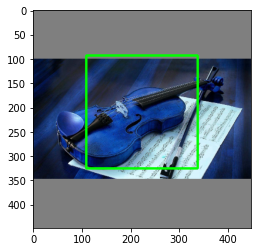

In [ ]:
test_image =Preprocess_input("/content/drive/MyDrive/Colab Notebooks/Yolo pose estimation draft(old)/test.jpg")
output = model.predict(test_image)
Preview_Output(output)